# Clonamos el repositorio para obtener los dataSet

In [185]:
!git clone https://github.com/joanby/tensorflow.git

Cloning into 'tensorflow'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 60311 (delta 32), reused 37 (delta 23), pack-reused 60260
Receiving objects: 100% (60311/60311), 442.46 MiB | 39.29 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Checking out files: 100% (60225/60225), done.


# Damos acceso a nuestro Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Test it

In [ ]:
!ls '/content/drive/My Drive' 

# Google colab tools

In [1]:
from google.colab import files # Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob # Para manejar los archivos y, por ejemplo, exportar a su navegador
from google.colab import drive # Montar tu Google drive

##Especificando la versión de TensorFlow

Ejecutando "importar tensorflow" importará la versión por defecto (actualmente 2.x). Puedes usar la 1.x ejecutando una celda con la "versión mágica de tensorflow" **antes de ejecutar "importar tensorflow".

### Si no funciona hacer el pip install


In [2]:
#!pip install tensorflow==1.14
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Importar Tensorflow

In [300]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

1.15.2


In [301]:
session = tf.Session()

# Red neuronal multicapa para predecir el bajo peso de un recién nacido

In [302]:
url = "https://raw.githubusercontent.com/joanby/tensorflow/master/datasets/birthweight.dat?token=AMRAeLOMrOCZKT3UgcdcA3VC4ep-4pYNks5cb-CGwA%3D%3D"
birth_file = requests.get(url)
birth_data = birth_file.text.split('\r\n')
birth_header = birth_data[0].split('\t')
birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]

In [303]:
birth_header

['LOW', 'AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI', 'BWT']

In [304]:
y_vals = np.array([x[8] for x in birth_data])
x_vals = np.array([x[1:8] for x in birth_data])

In [305]:
seed = 2019
tf.set_random_seed(seed)
np.random.seed(seed)
batch_size = 100

In [306]:
train_idx = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))

In [307]:
x_vals_train = x_vals[train_idx]
x_vals_test = x_vals[test_idx]
y_vals_train = y_vals[train_idx]
y_vals_test = y_vals[test_idx]

In [308]:
def normalize_cols(m, col_min = np.array([None]), col_max = np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return(m-col_min)/(col_max-col_min), col_min, col_max

In [309]:
x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test,_,_ = np.nan_to_num(normalize_cols(x_vals_test, train_min, train_max))

In [310]:
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape = shape, stddev=st_dev))
    return weight

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape = shape, stddev=st_dev))
    return bias

In [311]:
x_data = tf.placeholder(shape=[None, 7], dtype = tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [312]:
def full_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(layer)

- Dato de entrada: 7 -> capa oculta 1: 25, la capa tiene 7*25+25 = 200 variables
- Capa oculta 1: 25 -> capa oculta 2: 10, la capa tiene 25*10+10 = 260 variables
- Capa oculta 2: 10 -> capa oculta 3: 3, la capa tiene 10*3+3 = 33 variables
- Capa oculta 3: 3 -> Capa de Salida: 1, la capa tiene 3*1+1 = 4 variables

En total la red neuronal tiene que estimar 200+260+33+4 = 497 variables

In [313]:
w1 = init_weight(shape=[7,25], st_dev=10.0)
b1 = init_bias(shape=[25], st_dev=10.0)
layer1 = full_connected(x_data, w1, b1) 

w2 = init_weight(shape=[25,10], st_dev=10.0)
b2 = init_bias(shape=[10], st_dev=10.0)
layer2 = full_connected(layer1, w2, b2)

w3 = init_weight(shape=[10,3], st_dev=10.0)
b3 = init_bias(shape=[3], st_dev=10.0)
layer3 = full_connected(layer2, w3, b3)

w4 = init_weight(shape=[3,1], st_dev=10.0)
b4 = init_bias(shape=[1], st_dev=10.0)
layer4 = full_connected(layer3, w4, b4) 

In [314]:
loss = tf.reduce_mean(tf.abs(y_target-layer4))
my_optim = tf.train.AdamOptimizer(0.05)
train_step = my_optim.minimize(loss)
init = tf.global_variables_initializer()
session.run(init)

In [315]:
loss_vects = []
test_loss = []
for i in range(300):
    rand_idx = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_idx]
    rand_y = np.transpose([y_vals_train[rand_idx]])
    
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = session.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vects.append(temp_loss)
    
    test_temp_loss = session.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_loss.append(test_temp_loss)
    
    if(i+1)%25==0:
        print("Paso #"+str(i+1)+", Loss = "+str(temp_loss))

Paso #25, Loss = 20226.258
Paso #50, Loss = 3310.124
Paso #75, Loss = 944.71265
Paso #100, Loss = 1508.17
Paso #125, Loss = 706.84546
Paso #150, Loss = 846.6245
Paso #175, Loss = 1565.0657
Paso #200, Loss = 1271.3318
Paso #225, Loss = 1401.0514
Paso #250, Loss = 2564.7078
Paso #275, Loss = 1786.2312
Paso #300, Loss = 2219.197


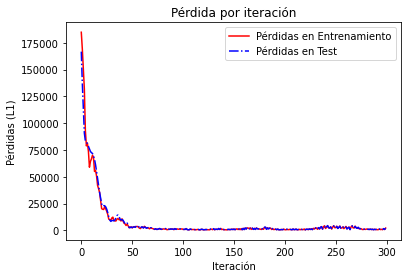

In [316]:
plt.plot(loss_vects, 'r-', label="Pérdidas en Entrenamiento")
plt.plot(test_loss, 'b-.', label="Pérdidas en Test")
plt.title("Pérdida por iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdidas (L1)")
plt.legend(loc="upper right")
plt.show()

In [317]:
actuals = np.array([x[0] for x in birth_data])
test_actuals = actuals[test_idx]
train_actuals = actuals[train_idx]
test_pred = [x[0] for x in session.run(layer4, feed_dict={x_data:x_vals_test})]
train_pred = [x[0] for x in session.run(layer4, feed_dict={x_data:x_vals_train})]
test_pred = np.array([1.0 if x<2500.0 else 0.0 for x in test_pred])
train_pred = np.array([1.0 if x<2500.0 else 0.0 for x in train_pred])

In [318]:
test_acc = np.mean([x==y for x,y in zip(test_pred, test_actuals)])
train_acc = np.mean([x==y for x,y in zip(train_pred, train_actuals)])

In [319]:
test_acc

0.3157894736842105

In [320]:
train_acc

0.31125827814569534